# Love in the Time of Correlation
## Statistical Significance on *The Good Place*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup #For web scraping
import time # To delay scraping 
import requests

import copy #To deep-copy dict of script strings
import random

#For hypothesis testing:
from scipy import stats #To find t and p values with ttests

<a id = "top"></a>

# Contents

[Web Scraping](#webscraping)

["Attempt Log"](#attemptlog)

## Custom functions

In [71]:
def get_season_urls(season_path):
    #Complete URL for the page with the links to the scripts for the season
    season_page = url_head + season_path
    page = requests.get(season_page)
    soup = BeautifulSoup(page.content, 'html.parser')
    urls_raw = soup.findAll('a', class_ = 'season-episode-title')

    eps = []
    
    #Add tuples to eps list for each url ending and its episode number
    for i, url_raw in enumerate(urls_raw):
        path = url_raw.get('href')
        ep = url_raw.get('href')[-6:-3]
        eps.append((path, ep))
    
    #Build a DataFrame from the list of tuples
    season_urls = pd.DataFrame(eps, columns = ['url', 'episode'])
    
    return season_urls

In [4]:
#Scrape a web page for a script
#Return it as a string
def get_script(script_path):
    #Complete URL for the page with the script
    script_page = url_head + script_path
    page = requests.get(script_page)
    soup = BeautifulSoup(page.content, 'html.parser')
    raw_script = soup.find('div', class_ = 'scrolling-script-container')
    
    return str(raw_script)

In [5]:
#helper function for clean()
def remove_linebreak(script):
    script = script.replace('\r', ' ')
    if '  ' in script:
        script = remove_whitespace(script)
    return script

In [6]:
#helper function for clean()
def remove_whitespace(script): 
    while '  ' in script:
        script = script.replace('  ', ' ')
    if '\r' in script:
        remove_linebreak(script)
    else:
        return script

In [7]:
#Removes white space and line breaks,
#splits the text into a list of lines of dialogue,
#with each line numbered.
#Returns a list of tuples.
def clean(raw_script):
    #Call remove_linebreak and remove_whitespace recursively until 
    #all line breaks and whitespaces are removed.
    cleaned_script = remove_linebreak(raw_script)
    #Split the script into a list of lines of dialogue.
    split_script = cleaned_script.split('<br/>')
    tupled_script = []
    #Turn the lines into tuples to record the numbering.
    for i, line in enumerate(split_script):
        tupled_script.append((i, line))
    return tupled_script

In [8]:
#Find and return lines of dialogue with digits in them
#Captures numerals with commas like "125,000."
#Split the line into individual characters 
#and return True if a numeral is found.
def has_numbers(line):    
    letters = list(line)
    for letter in letters:
        if letter.isdigit():
            return True

In [9]:
#Returns dict with all all topical lines from the given scripts
def find_lines(topics, scripts):
    
    #Build new dict of episodes with only the topical lines of dialogue
    scripts_with_topical_lines = {}
    #Step 1: Iterate over each script in the dict
    for key, val in scripts.items():
        #Add the key for a given script to the new dict with an
        #empty list as its value.
        scripts_with_topical_lines[key] = []
        #Step 2: For each script, iterate over each line
        for i, line in val:
            #Step 3: Look for topical words by calling is_topical() on the line
            if is_topical(topics, line):
                #Step 4: Add the tuple of the line to the list for 
                #that script in the new dict of scripts.
                scripts_with_topical_lines[key].append((i, line))
    
    return scripts_with_topical_lines

In [10]:
#helper function for find_lines
#Find and return only topical lines
def is_topical(topics, line):
    #Look for topical words
    if any(topic in line for topic in topics):
            return True

In [11]:
#Print all the the lines from a given set of scripts
def print_lines(lines):
    for key, val in lines.items():
        if val:
            print(key)
            for line in val:
                print(line)
            print('\n')

In [12]:
#to append to the beginning of URL scraped from website
url_head = 'https://www.springfieldspringfield.co.uk/'

<a id = "webscraping"></a>

[(Back to top)](#top)

## Web scraping to gather data

### Get URLs for all pages with scripts

In [72]:
#Gather the URLs for each script page, by season
s01_urls = get_season_urls('episode_scripts.php?tv-show=the-good-place-2016&season=1')
s02_urls = get_season_urls('episode_scripts.php?tv-show=the-good-place-2016&season=2')
s03_urls = get_season_urls('episode_scripts.php?tv-show=the-good-place-2016&season=3')

In [73]:
s01_urls

,url,episode
0,view_episode_scripts.php?tv-show=the-good-plac...,s01
1,view_episode_scripts.php?tv-show=the-good-plac...,s01
2,view_episode_scripts.php?tv-show=the-good-plac...,s01
3,view_episode_scripts.php?tv-show=the-good-plac...,s01
4,view_episode_scripts.php?tv-show=the-good-plac...,s01
5,view_episode_scripts.php?tv-show=the-good-plac...,s01
6,view_episode_scripts.php?tv-show=the-good-plac...,s01
7,view_episode_scripts.php?tv-show=the-good-plac...,s01
8,view_episode_scripts.php?tv-show=the-good-plac...,s01
9,view_episode_scripts.php?tv-show=the-good-plac...,s01


In [74]:
#Get s01e01, s2e01, and s03e01
s01e01 = s01_urls.iloc[[0]]
s01e01['episode'] = s01e01['episode'] + 'e0' + str(1) # DOESN'T WORK
s02e01 = s02_urls.iloc[[0]]
s03e01 = s03_urls.iloc[[0]]

In [81]:
#### START HERE NEXT
### TRYING TO CHANGE NAME OF EPISODE

In [ ]:
s01e01

In [75]:
#Append the rest of each season to the first episode
s01_urls = pd.concat([s01e01, s01_urls], axis = 0, ignore_index = True)

s02_urls = pd.concat([s02e01, s02_urls], axis = 0, ignore_index = True)

s03_urls = pd.concat([s03e01, s03_urls], axis = 0, ignore_index = True)

In [76]:
for i in range(1,14)
    s01_urls.iloc

,url,episode
0,view_episode_scripts.php?tv-show=the-good-plac...,s01
1,view_episode_scripts.php?tv-show=the-good-plac...,s01
2,view_episode_scripts.php?tv-show=the-good-plac...,s01
3,view_episode_scripts.php?tv-show=the-good-plac...,s01
4,view_episode_scripts.php?tv-show=the-good-plac...,s01
5,view_episode_scripts.php?tv-show=the-good-plac...,s01
6,view_episode_scripts.php?tv-show=the-good-plac...,s01
7,view_episode_scripts.php?tv-show=the-good-plac...,s01
8,view_episode_scripts.php?tv-show=the-good-plac...,s01
9,view_episode_scripts.php?tv-show=the-good-plac...,s01


In [ ]:
#Correct names of episodes in seasons 2 and 3
for i, row in enumerate(s02_urls):
    row['episode'] = row['episode'

In [66]:
#Combine into one dataframe with all urls for scripts
season_urls = pd.concat([s01_urls, 
                         s02e01, 
                         s02_urls, 
                         s03e01, 
                         s03_urls], 
                        axis = 0, ignore_index = True)

In [67]:
#Manually add in 'e02' for season 2 to line up episode numbering
#to accunt for two-part season openers

season_urls

#Manually add in 'e03' for season 2 to line up episode numbering
#to accunt for two-part season openers

,url,episode
0,view_episode_scripts.php?tv-show=the-good-plac...,s01
1,view_episode_scripts.php?tv-show=the-good-plac...,s01
2,view_episode_scripts.php?tv-show=the-good-plac...,s01
3,view_episode_scripts.php?tv-show=the-good-plac...,s01
4,view_episode_scripts.php?tv-show=the-good-plac...,s01
5,view_episode_scripts.php?tv-show=the-good-plac...,s01
6,view_episode_scripts.php?tv-show=the-good-plac...,s01
7,view_episode_scripts.php?tv-show=the-good-plac...,s01
8,view_episode_scripts.php?tv-show=the-good-plac...,s01
9,view_episode_scripts.php?tv-show=the-good-plac...,s01


In [63]:
season_urls.loc[[13] ]

,url,episode
13,view_episode_scripts.php?tv-show=the-good-plac...,s02


In [ ]:
line = DataFrame({"onset": 30.0, "length": 1.3}, index=[2.5])
df = df.append(line, ignore_index=False)
df = df.sort_index().reset_index(drop=True)

In [54]:
season_urls.iloc[[12]] #season 2 episode 1

,url,episode
12,view_episode_scripts.php?tv-show=the-good-plac...,s02


In [57]:
season_urls.iloc[[24]] #season 3 episode 1

,url,episode
24,view_episode_scripts.php?tv-show=the-good-plac...,s03


### Get script for each episode

In [15]:
#empty dict of raw script strings
raw_scripts = {}

In [16]:
#Iterate over rows of the DF as tuples
#Populate dict of raw scripts
#Includes a time lag so that the remote server
#doesn't get too many requests too fast.
for row in season_urls.itertuples(index = False):
    #get script by scraping site and append to dict
    raw_scripts[row.episode] = get_script(row.url)
    #wait 3 seconds
    time.sleep(1)

In [ ]:
#Manually separate s01312 and s01e13
#
#
#


In [17]:
#Make a new dict of scripts to clean up
scripts = copy.deepcopy(raw_scripts)

In [18]:
#Clean all scripts to turn each into a list of strings of dialogue
for key, val in scripts.items():
    scripts[key] = clean(val)

# Lines about the system

In [30]:
the_system = ['system']

In [31]:
system_lines = find_lines(the_system, scripts)

In [32]:
print_lines(system_lines)

s01e01
(64, ' [laughter] Anyway, when your time on Earth has ended, we calculate the total value of your life using our perfectly accurate measuring system.')
(83, " Again, it's an incredibly selective system.")
(94, ' Now, let me show you the, uh the video system here.')
(331, ' Well, then this system sucks.')
(370, " See, that's the trouble with these perfect systems.")
(511, " We switched to a rotating system for choosing a designated driver, and it's your turn.")
(513, ' Full disclosure, I forgot we were doing this new system.')
(518, " Guess the only place I'll be driving is through the giant loophole in the system I accidentally discovered.")
(529, " Oh, Tahani, if I made one tiny mistake in my design, if there's a single glitch in the system, if even one blade of grass is angled a a fraction of a degree off [dog whimpers] The whole neighborhood is compromised.")


s01e08
(4, " Our system has never made a mistake before It's just not possible.")
(232, ' I just want to say, once m

s01e01
(64, ' [laughter] Anyway, when your time on Earth has ended, we calculate the total value of your life using our perfectly accurate measuring system.')
(83, " Again, it's an incredibly selective system.")
(370, " See, that's the trouble with these perfect systems.")

s01e08
(4, " Our system has never made a mistake before It's just not possible.")

s01e10
(190, ' - Of course, the system did screw up by letting Fake Eleanor in.')
(195, " I mean, the system might be so screwed up at this point that maybe you don't belong to either Eleanor.")

s02e01
(180, " Now, normally, our omniscient system perfectly analyzes each person's profile, and then matches him or her with another person.")

s02e12
(3, " The premise of our system is that a person's score during her time on Earth is final and inarguable, but because of my accidental experiment, these four humans got better after they died.")
(15, " If I'm right, the system by which we judge humans the very method we use to deem them good or bad is so fundamentally flawed and unreasonable that hundreds of millions of people have been wrongly condemned to an eternity of torture.")
(85, ' Why should we have to go live alone in a boring void because of a messed-up system? - How is that justice? - Okay.')

s03e01
(366, " [TENSE MUSIC] - [COMPUTER BEEPS] - Aha! Someone just went down to Earth, and that gave me a back door into The Judge's system.")

s03e04
(164, " It's a perfect system.")

s03e09
(136, ' [whooshing] The system is flawless, and tampering is quite impossible.')

s03e11
(140, ' Shawn, I have reason to believe that humans might be, on average, better than the points system suggests they are.')

# Lines about Janet

In [42]:
janet = ['janet', 'robot', 'know everything about', 'knowledge', 'updat', 'database']

In [43]:
janet_lines = find_lines(janet, scripts)

In [44]:
print_lines(janet_lines)

s01e01
(161, " She's like this walking database.")
(355, ' Hey, how do I make that helper woman show up? Hello? Front desk lady? Magical slave robot? Excuse me, Janet? - Hi there.')


s01e06
(124, ' [robotically] Does not compute.')


s01e07
(181, ' Each new update of Janet gains more wisdom and social abilities.')
(207, ' I am simply an anthropomorphized vessel of knowledge built to make your life easier.')
(210, ' Ugh, you want a robot killed right, you have to do it yourself.')
(272, " Uh, her memory must have been wiped clean, so now she's gonna have to re-upload all the knowledge in the universe, which will only take a few days.")
(336, ' I want to keep you all updated.')


s01e10
(288, '" - [gags] - "Jacksonville Jaguars rule!" Jason, when I was rebooted, and I lost all my knowledge, I was confused and disoriented, but you were always kind to me.')


s01e11
(113, ' As you know, each time I am updated, I accrue new knowledge and abilities.')


s01e12
(484, " Oh, that's enough out 

s01e01
(161, " She's like this walking database.")

s01e07
(181, ' Each new update of Janet gains more wisdom and social abilities.')
(207, ' I am simply an anthropomorphized vessel of knowledge built to make your life easier.')
(272, " Uh, her memory must have been wiped clean, so now she's gonna have to re-upload all the knowledge in the universe, which will only take a few days.")

s01e09
(146, " I mean, it does matter if I know things, because I'm an informational delivery system, and I don't have a heart, but thanks.")

s01e10
(288, '" - [gags] - "Jacksonville Jaguars rule!" Jason, when I was rebooted, and I lost all my knowledge, I was confused and disoriented, but you were always kind to me.')


s01e11
(113, ' As you know, each time I am updated, I accrue new knowledge and abilities.')

s02e05
(75, ' I am simply a vessel containing all of the knowledge in the universe.')

s02e06
(191, ' Say what now? After the very first time you were rebooted, and as you were slowly regaining your knowledge, you bonded with Jason.')

(358, " You contain all the knowledge in the universe, you have a rippin' bod, and you can literally do anything.")

s02e09
(138, ' In case you were wondering, I am by definition the best version of myself, because my operating system is always updating.')

s02e11
(47, " Wait, you don't already know everything about us? You're not omniscient? Well Not in the way you mean.")

s03e02
(127, ' Ever since we walked through that portal, my knowledge has stopped updating.')

s03e05
(29, ' I do know everything about you and Simone and computer programming and virtual reality and artificial intelligence and the human brain and everything else.')

s03e12
(43, ' Janet is a walking database of all the knowledge in the universe, and since you, John, seem to like asking a relentless number of questions, go ahead.')

In [26]:
scripts['s03e02']

[(0,
  '<div class="scrolling-script-container"> \n \n \n \t\t\tMichael, a demon has infiltrated the group.'),
 (1, ' Not just any demon.'),
 (2, ' Trevor is a diabolical, sadistic agent of evil.'),
 (3, ' Might just be the single most dangerous creature in the universe.'),
 (4,
  " Who wants lemon bars? It's my nana's recipe, and they are just sinful."),
 (5, " Love 'em on my lips but hate 'em on my hips, if you know what I mean."),
 (6, ' All right, new guy, coming in strong with free dessert.'),
 (7, ' You must be Eleanor, the reason this is all happening.'),
 (8, ' I am.'),
 (9,
  ' It\'s so nice to hear someone say, "Eleanor, you\'re the reason this is all happening" who isn\'t a judge in small claims court.'),
 (10, ' Thank you for this, Eleanor.'),
 (11, " It's a wonderful thing you've done."),
 (12, ' Mm, happy to help you out, buddy.'),
 (13, " Oh, we're doing a long hug."),
 (14,
  " Are you crying? Sorry, I'm just I'm just so happy to be here, if that makes sense."),
 (15, '

In [21]:
#Mihael tells Eleanor about falling in love with Chidi
scripts['s03e06']

[(0,
  '<div class="scrolling-script-container"> \n \n \n \t\t\t1 So my mom is alive, and she lives here.'),
 (1,
  " Why didn't you tell me sooner, man? I had already told you that you died and that I had tortured you for centuries and that you're doomed to be tortured again."),
 (2, " I just didn't want to be, like, a bummer."),
 (3, ' But now you know everything important about your life.'),
 (4, ' I promise.'),
 (5,
  ' A police officer came to my home and told me that my mom had been accidentally trampled to death when she bent down to adjust her toe ring at a Rascal Flatts concert.'),
 (6, ' That police officer was an actor.'),
 (7,
  ' See, about a month before, your mom had gotten drunk, wandered into a charity auction, and bid $30,000 for a date with Gene Simmons, outbidding everyone else by $29,800.'),
 (8,
  " She didn't want to pay, so she faked her death, moved to Nevada, and reinvented herself as Diana Tremaine."),
 (9, ' Diana Tremaine is my fake ID name.'),
 (10,
  " - 

 s03e07
 (337,
  ' In one of the reboots, you and Chidi fell in love deeply, and you told him that you loved him, and he told you that he loved you back.')

# Lines about numbers

In [18]:
#empty dict for episodes with lists of lines of 
#dialogue containing numbers
number_lines_from_scripts = {}

In [19]:
number_words = ['two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', ' ten ',
           'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen', 'eighteen', 'nineteen',
           'twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety',
            'hundred', 'thousand', 'million', 'billion', 'trilion',
            'first', 'second', 'third', 'fifth', 'ninth']

In [20]:
#Redundant to find_lines() for now.
#Build new dict of episodes with only the lines of dialogue
#containing number words.
#Step 1: Iterate first over each script in the dict
for key, val in scripts.items():
    #Add the key from scripts to the new dict
    number_lines_from_scripts[key] = []
    #Step 2: For each script, iterate over each line
    for i, line in val:
        #Step 3: Look for number words
        if is_topical(number_words, line):
            #Step 4: Add the line to the list of lines for 
            #that script in the new dict.
            number_lines_from_scripts[key].append((i, line))
        #If the line doesn't have spelled-out number words,
        #check for digits. Add the line when the first digit
        #is found.
        elif has_numbers(line):
            number_lines_from_scripts[key].append((i, line))

In [24]:
#for testing
number_lines_from_scripts['s01e01']

[(0,
  '<div class="scrolling-script-container"> \n \n \n \t\t\t1 [light chime music] [sighs] [door clicks open] Eleanor? Come on in.'),
 (20,
  '" Funnily enough, the first EMT to arrive was an ex-boyfriend of yours Okay, that\'s I get it, thank you.'),
 (24,
  ' Jews, Christians, Buddhists, every religion guessed about 5%, except for Doug Forcett.'),
 (25,
  " Who who's Doug Forcett? Well, Doug was a stoner kid who lived in Calgary during the 1970s."),
 (26,
  ' One night, he got really high on mushrooms, and his best friend, Randy, said, "Hey, what do you think happens after we die?" And Doug just launched into this long monologue where he got like 92% correct.'),
 (42,
  ' Each one contains exactly 322 people who have been perfectly selected to blend together into a blissful harmonic balance.'),
 (52, " You're gonna have a million more questions, I know."),
 (57, ' - And welcome to your first day in the afterlife.'),
 (76,
  " You know the way you feel when you see a picture of two

## "Points" lines

In [24]:
points = [' point', ' earn', ' lose', 'lost', 'losing']

In [25]:
points_lines = find_lines(points, number_lines_from_scripts)

In [26]:
print_lines(points_lines)

s01e06
(0, '<div class="scrolling-script-container"> \n \n \n \t\t\t1 [upbeat music] - What are you doing? - [gasps] Dude, I\'m freaked out about my meeting with Michael, and if I spend one more second staring at Creepo the Clown, I\'m gonna lose it.')
(152, " Now, what should we do first? both: I'm going out In a blaze of glory Lord, I never drew first But I drew first blood And I'm no one's son So call me young gun Whoo! This is so interesting! I mean, there's no point to it.")


s01e08
(184, ' [door opens] You guys, what is happening? Someone egged my Lexus, and I have like 40,000 tweets calling me the "Dress Bitch"? Over a loser dry cleaner man? Why is everyone so jealous of me? This is a trash city full of idiots.')


s01e11
(9, ' Now, the average point total for a resident here is roughly 1.')
(13, ' - [beep] - You just lost five points.')
(18, " - Look, I know this is tedious, but holding a door for someone is three points, and if you do it for everyone in the neighborhood, then

s01e11
(9, ' Now, the average point total for a resident here is roughly 1.'),
 (10, '2 million.')
 
  (140, ' Tell her you love her.'),
 (141, ' [beep] Hey, your score just went up 20 points.')

In [29]:
scripts['s01e11']

[(0,
  '<div class="scrolling-script-container"> \n \n \n \t\t\t1 Now, I\'m about to show you some very sensitive information.'),
 (1,
  ' The final point totals each of you achieved for all your actions on Earth.'),
 (2, ' [ping] Whoa, your point total was crazy high, Eleanor.'),
 (3, ' [laughs] Oh, sorry, "Crazy High Eleanor" was my nickname in college.'),
 (4,
  ' I accidentally saw these point totals when Michael was fixing the sinkhole.'),
 (5, ' It gave me an idea.'),
 (6,
  " We will apply the formula to Eleanor's actions here in the Good Place, and if you earn enough new points, then we could argue that you should stay here."),
 (7,
  " - Would that work? - Don't know, never had to prove someone belonged here before."),
 (8,
  ' But the judge will be here soon, and this is the best way to build our case.'),
 (9, ' Now, the average point total for a resident here is roughly 1.'),
 (10, '2 million.'),
 (11,
  ' Right now, based on everything that you did on Earth, you have -4,008

## "Attempts" lines

In [49]:
attempts = ['attempt', 'try', 'tries', 'tried', 'version', 'experiment', 'time']

In [50]:
attempt_lines = find_lines(attempts, number_lines_from_scripts)

In [51]:
print_lines(attempt_lines)

s01e01
(386, ' That was my first time as a fashion "don\'t," and I did not care for it.')


s01e04
(267, " But first, I'd like to try something fun.")
(363, " I read this entire David Hume book, and then I read it again because I didn't understand it the first time, and now I'm ready to go.")
(373, ' I just have two questions: when are football tryouts? And does this school have a prom? Oh, no.')
(375, " For the first time ever, I'm the smartest kid in class.")


s01e05
(190, " Yeah, I noticed! You know what, man? I have spent every second in this place worried I was gonna get caught, but if we go down right now, that's on you, okay? Oh, you spend all your time teaching a charming, awesome lady? How sad for you.")


s01e06
(204, ' And do you like France as much as I do? Well, they enslaved my country for 300 years.')


s01e07
(64, '" Could you describe it? It\'s the color of [sighs] When a soldier comes home from war and sees his dog for the first time.')
(299, " - What? I told you tha

## All "time" lines

In [52]:
time = ['second', 'minute', 'day', 'week', 'month', 'year']

In [54]:
time_lines = find_lines(time, number_lines_from_scripts)

In [55]:
print_lines(time_lines)

s01e01
(57, ' - And welcome to your first day in the afterlife.')
(76, " You know the way you feel when you see a picture of two otters holding hands? That's how you're gonna feel every day.")
(148, ' I was the top salesperson five years running.')
(217, ' Do you have a second to talk about the environment? Do you have a second to eat my farts? You missed.')
(233, '" And I know we just met on this bus ten minutes ago, but he seemed nice.')
(238, ' I had been an apprentice for over 200 years, and my boss has finally given me my first solo project.')
(435, ' Welcome to orientation, day two.')
(559, ' But in my defense, there were only five minutes left in flying and I wanted to go flying.')


s01e03
(43, ' Yes, I spent 18 years working on my manuscript called "Who We Are and Who We Are Not colon "Practical Ethics and Their Application in the Modern World semi-colon a Treatise" Yes, yes, yes, that\'s the one.')
(212, ' This took me two weeks to get through.')


s01e04
(70, " [laughing] I 

### All "topical" dialogue from which to get parameters

In [ ]:
topics = ['point', 'points', 'second', 'seconds',  'minute',
              'minutes', 'day', 'days', 'week', 'weeks', 
              'month', 'months', 'year', 'years', 'time', 'times',
             'people', 'humans', 'attempt', 'attempts',
              'try', 'tries', 'version', 'versions']

In [ ]:
all_topical = find_lines(topics, number_lines_from_scripts)

In [41]:
print_lines(all_topical)

s01e01
(42, ' Each one contains exactly 322 people who have been perfectly selected to blend together into a blissful harmonic balance.')
(57, ' - And welcome to your first day in the afterlife.')
(76, " You know the way you feel when you see a picture of two otters holding hands? That's how you're gonna feel every day.")
(148, ' I was the top salesperson five years running.')
(175, " [people yelling and screaming, mechanical buzzing] - The bear has two mouths! - [people screaming] [sound stops] Well, it doesn't sound awesome.")
(217, ' Do you have a second to talk about the environment? Do you have a second to eat my farts? You missed.')
(233, '" And I know we just met on this bus ten minutes ago, but he seemed nice.')
(238, ' I had been an apprentice for over 200 years, and my boss has finally given me my first solo project.')
(386, ' That was my first time as a fashion "don\'t," and I did not care for it.')
(435, ' Welcome to orientation, day two.')
(457, " Whoo! [woman laughing] - 

### Dig further into a script

In [472]:
scripts['s01e12']

['<div class="scrolling-script-container"> \n \n \n \t\t\t1 And now The end is near And so I face The final curtain - Ow! What the hell? - Walk it off, Lululemon.',
 ' I\'ll say it clear I\'ll state my case Of which I\'m certain I\'ve lived A life that\'s full I traveled each and "Live every day like it\'s your last.',
 '" Bite me.',
 " I'ma live forever, bitch.",
 " Ma'am? It's $132.",
 '21.',
 ' So, big plans this weekend? Yep.',
 " I'm gonna sit alone in my house watching wedding fails on YouTube, drinking margaritas through a Twizzlers straw until I pass out on top of my vibrator.",
 ' Hi there.',
 ' Do you have a second to talk about the environment? No.',
 ' Buzz off, whale-humper.',
 " You know, I see you here all the time, and you're always mean to me, and it really hurts my feelings.",
 " It does? Because the minute you're out of my line of sight, I literally forget you exist.",
 ' Watch.',
 ' You exist.',
 " You don't exist.",
 " You're bothering me.",
 " Don't care if you di

<a id = "attemptlog"></a>

[(Back to top)](#top)

# "Attempt log"

In [470]:
random.seed(11)

#How long it took Eleanor to figure out she wasn't in The Good Place
#max: 11 months  at 770th attempt
max_ = 334
max_index = (771)

#min: 8 seconds at 556th attempt
min_ = 8 / 86400
min_index = (557)

#total attempts: 802
pop_size = 802

#This distribution gets pretty close. 
#Use 800 random values with a max of 9 months.
attempts = np.random.randint(low = 10, high = 270, size = pop_size - 2)

#manually add an 11-second value and an 11-month value.
attempts = np.insert(attempts, min_index, min_)
attempts = np.insert(attempts, max_index, max_)

#All attempts together should add up to around 300 years
attempts.sum() / 365

309.23835616438356

<BarContainer object of 802 artists>

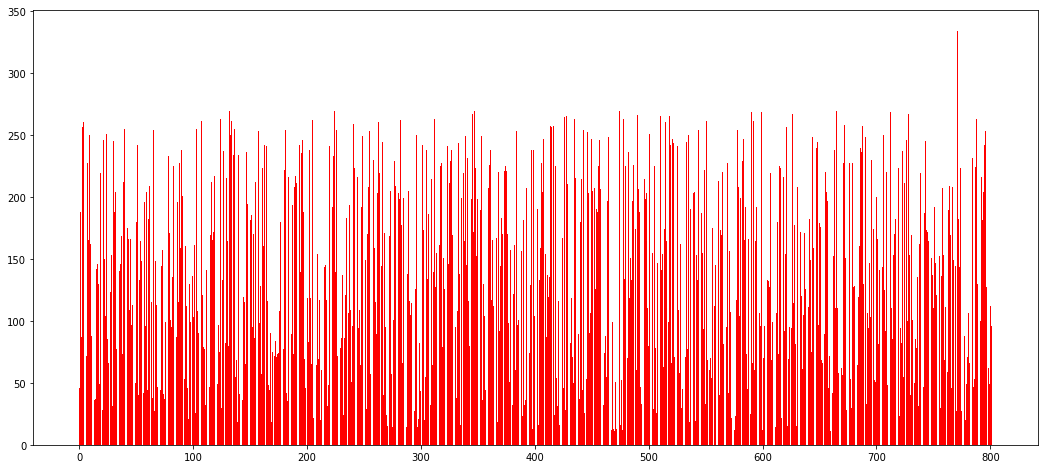

In [471]:
#plot attempts as bar graph
fig = plt.figure(figsize = (18,8))
plt.bar(range(pop_size), attempts, color = 'red')

(array([ 1.,  0., 10., 16.,  9., 18.,  7.,  7., 13., 14.,  8., 13.,  9.,
         6., 10., 12., 11., 13., 11., 13., 15., 15., 15., 17.,  7., 10.,
        12.,  9., 17., 20., 14., 18., 10., 19., 20., 17., 15., 10., 12.,
        12., 15., 11., 10.,  9., 12., 14., 13., 19., 14., 10., 16., 14.,
        10., 11., 12., 19., 11., 12., 15., 14., 10., 11., 18., 12.,  4.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.]),
 array([  0.   ,   4.175,   8.35 ,  12.525,  16.7  ,  20.875,  25.05 ,
         29.225,  33.4  ,  37.575,  41.75 ,  45.925,  50.1  ,  54.275,
         58.45 ,  62.625,  66.8  ,  70.975,  75.15 ,  79.325,  83.5  ,
         87.675,  91.85 ,  96.025, 100.2  , 104.375, 108.55 , 112.725,
        116.9  , 121.075, 125.25 , 129.425, 133.6  , 137.775, 141.95 ,
        146.125, 150.3  , 154.475, 158.65 , 162.825, 167.   , 171.175,
        175.35 , 179.525, 183.7  , 187.875, 192.05 , 196.225, 200.4  ,
        204.575, 208.75 , 212.925, 217.1  , 2

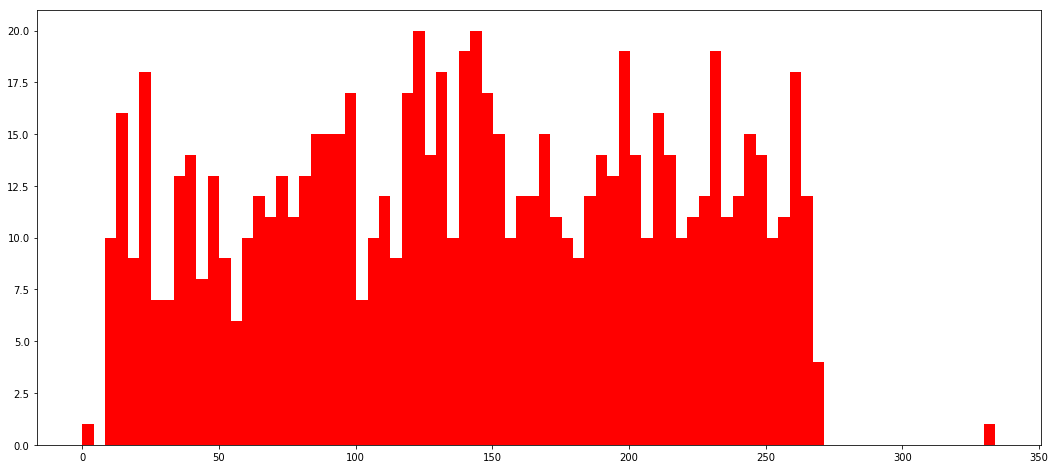

In [453]:
fig = plt.figure(figsize = (18,8))
plt.hist(attempts, bins = 80, color = 'red')

C:\Users\Stee\Anaconda3good\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


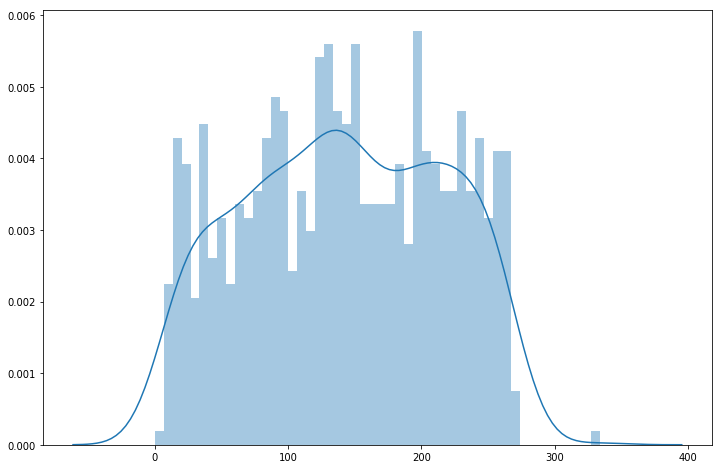

In [457]:
#plot attempts
fig = plt.figure(figsize = (12, 8))
sns.distplot(attempts, bins = 50)

## Hypothesis 1: Length of experiment

     s01e12
     (562, Michael: 'I think that we can get them to torture each other for 1,000 years.')
     (563, Sean: 'I think you'll be lucky to get six months out of this insane gambit.')



In [459]:
alpha = 0.05
seans_mean = (31 * 3) + (30 * 2) + 28 #181 days
michaels_mean = 365 * 1000 #1000 years

In [467]:
#Test Sean's mean
test_statistic, pvalue = stats.ttest_1samp(attempts, seans_mean)
print('Test statistic:', test_statistic)
print('P value:', pvalue)
print('Sean\'s mean:', seans_mean)
print('Sample mean:', attempts.mean())

Test statistic: -14.850679941463795
P value: 3.0096293345151445e-44
Sean's mean: 181
Sample mean: 142.31795511221947


In [469]:
#Test Michael's mean
test_statistic, pvalue = stats.ttest_1samp(attempts, michaels_mean)
print('Test statistic:', test_statistic)
print('P value:', pvalue)
print('Michael\'s mean:', michaels_mean)
print('Sample mean:', attempts.mean())

Test statistic: -140074.92819865452
P value: 0.0
Michael's mean: 365000
Sample mean: 142.31795511221947
